In [23]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train.csv')
test = pd.read_csv('/Users/siero5335/channel/test.csv')


sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

In [27]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

In [28]:
# https://www.kaggle.com/friedchips/clean-removal-of-data-drift
train_segm_separators = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])
train_segm_signal_groups = [0,0,0,1,2,4,3,1,2,3,4] # from visual identification
train_segm_is_shifted = [False, True, False, False, False, False, False, True, True, True, True] # from visual identification
train_signal = np.split(train['signal'].values, train_segm_separators[1:-1])
train_opench = np.split(train['open_channels'].values, train_segm_separators[1:-1])

In [29]:
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
test_segm_is_shifted = [True, True, False, False, True, False, True, True, True, False, True, False] # from visual id
test_signal = np.split(test['signal'].values, test_segm_separators[1:-1])

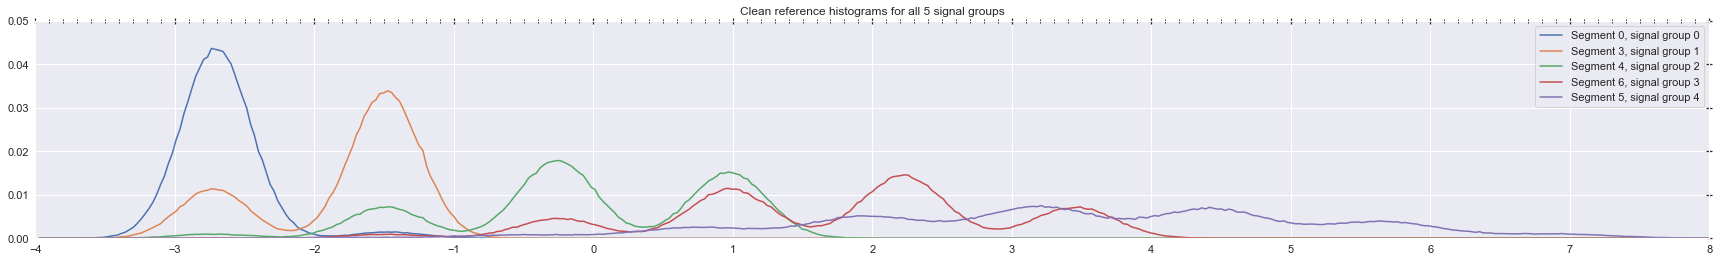

In [30]:
#create clean signal histograms
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[-4,8,1,.1], y_val=[0,0.05,0.01,0.01])

clean_hist = []
hist_bins = np.linspace(-4,10,500)

for j,i in enumerate([0,3,4,6,5]):
    clean_hist.append(np.histogram(train_signal[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000 # normalize histogram
    axes.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j));
axes.legend();
axes.set_title("Clean reference histograms for all 5 signal groups");

In [31]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10 # maximum absolute change in shift from window to window+1
train_signal_shift = []

for clean_id in range(len(train_segm_signal_groups)):
    
    group_id = train_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0 # all signal groups start with shift=0
    window_data = train_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    train_signal_shift.append(window_shift)    

In [32]:
bin_width = np.diff(hist_bins)[0]
s_window = 10
test_signal_detrend = []
test_signal_shift = []

for clean_id in range(len(test_segm_signal_groups)):
    
    group_id = test_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0
    window_data = test_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    test_signal_shift.append(window_shift)    


In [33]:
train_signal_shift_clean = []
train_signal_detrend = []

for data, use_fit, signal in zip(train_signal_shift, train_segm_is_shifted, train_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    train_signal_shift_clean.append(data_2)
    train_signal_detrend.append(signal + data_2)

In [35]:
test_signal_shift_clean = []
test_signal_detrend = []
test_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(test_signal_shift, test_segm_is_shifted, test_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    test_signal_shift_clean.append(data_2)
    test_signal_detrend.append(signal + data_2)

In [40]:
train['signal'] = np.concatenate(train_signal_detrend)
test['signal'] = np.concatenate(test_signal_detrend)

In [41]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [42]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

In [43]:
def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [44]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p5(x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95( x : pd.Series) -> pd.Series : return x.quantile(0.95)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

In [45]:
zscore = lambda x: (x - x.mean()) / x.std()

window_sizes = [10, 50, 100, 500, 1000]

for window in window_sizes:
    train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
    train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
    train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
for window in window_sizes:
    test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
    test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
    test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
    test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
                                            
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['skew'+c] = df.groupby([c])['signal'].skew()
        
        d['q1'+c] = df.groupby([c])['signal'].apply(lambda x:p1(x))
        d['q5'+c] = df.groupby([c])['signal'].apply(lambda x:p5(x))
        d['q95'+c] = df.groupby([c])['signal'].apply(lambda x:p95(x))       
        d['q99'+c] = df.groupby([c])['signal'].apply(lambda x:p99(x))                   
        
        d['signal_batch'+c] = df.groupby([c])['signal'].transform(zscore)
        d['perm'+c] = df.groupby([c])['signal'].apply(lambda x:perm_entropy(x))
        d['higuchi'+c] = df.groupby([c])['signal'].apply(lambda x:higuchi_fd(x))
        d['katz'+c] = df.groupby([c])['signal'].apply(lambda x:katz_fd(x))
                
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan
        
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

train_y = train['open_channels']

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
train.head()

,time,signal,open_channels,rolling_mean_10,rolling_std_10,rolling_min_10,rolling_max_10,rolling_mean_50,rolling_std_50,rolling_min_50,...,higuchibatch_slices2_msignal,katzbatch_slices2_msignal,mean_abs_chgbatch_slices2_msignal,abs_maxbatch_slices2_msignal,abs_minbatch_slices2_msignal,rangebatch_slices2_msignal,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift_+1_msignal,signal_shift_-1_msignal
0.0,0.0001,-2.7600,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.75845603,9.84520065,3.02972949,6.3496,4.6226,4.4870,3.2788879,5.4861,0.0000,-0.0957
1.0,0.0002,-2.8557,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.85415603,9.94090065,3.12542949,6.4453,4.7183,4.5827,3.3745879,5.5818,0.0957,0.4483
2.0,0.0003,-2.4074,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.40585603,9.49260065,2.67712949,5.9970,4.2700,4.1344,2.9262879,5.1335,-0.4483,-0.7330
3.0,0.0004,-3.1404,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.13885603,10.22560065,3.41012949,6.7300,5.0030,4.8674,3.6592879,5.8665,0.7330,-0.0121
4.0,0.0005,-3.1525,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.15095603,10.23770065,3.42222949,6.7421,5.0151,4.8795,3.6713879,5.8786,0.0121,0.5107


In [47]:
test.head()

,time,signal,rolling_mean_10,rolling_std_10,rolling_min_10,rolling_max_10,rolling_mean_50,rolling_std_50,rolling_min_50,rolling_max_50,...,higuchibatch_slices2_msignal,katzbatch_slices2_msignal,mean_abs_chgbatch_slices2_msignal,abs_maxbatch_slices2_msignal,abs_minbatch_slices2_msignal,rangebatch_slices2_msignal,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift_+1_msignal,signal_shift_-1_msignal
5000000.0,500.0001,-2.67534728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.67699573,9.83817924,2.94607662,6.23976232,4.54398610,4.37112351,3.19959567,5.39187421,0.00000000,-0.19963165
5000001.0,500.0002,-2.87497894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.87662738,10.03781089,3.14570827,6.43939397,4.74361775,4.57075516,3.39922732,5.59150586,0.19963165,-0.01063165
5000002.0,500.0003,-2.88561059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.88725903,10.04844254,3.15633992,6.45002562,4.75424940,4.58138681,3.40985897,5.60213751,0.01063165,0.42496835
5000003.0,500.0004,-2.46064224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.46229068,9.62347419,2.73137157,6.02505727,4.32928105,4.15641846,2.98489062,5.17716916,-0.42496835,-0.18053165
5000004.0,500.0005,-2.64117389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.64282233,9.80400584,2.91190322,6.20558892,4.50981270,4.33695011,3.16542227,5.35770081,0.18053165,0.04956835


In [48]:
#train.to_csv('/Users/siero5335/channel/train_mod.csv')
#test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [49]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [50]:
from sklearn import model_selection
train_features, valid_features, train_labels, valid_labels = model_selection.train_test_split(train, train_y, test_size=0.2)

In [51]:
trains = lgb.Dataset(train_features, train_labels)
valids = lgb.Dataset(valid_features, valid_labels)

In [52]:
params = {
    'learning_rate': 0.3, 
    'metric': 'l1',
    'bagging_fraction': 1.0,
    'bagging_freq': 0
}
best_params, history = {}, []
model = lgbopt.train(params, trains, valid_sets=valids,
                    verbose_eval=False,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    best_params=best_params,
                    tuning_history=history)

tune_num_leaves, val_score: 0.047707: 100%|##########| 20/20 [21:23<00:00, 64.17s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.047707:  10%|#         | 1/10 [00:21<03:11, 21.31s/it][I 2020-03-14 09:08:43,382] Finished trial#0 resulted in value: 0.048141573997612895. Current best value is 0.048141573997612895 with parameters: {'bagging_fraction': 0.5186022246089713, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047707:  20%|##        | 2/10 [00:52<03:13, 24.25s/it][I 2020-03-14 09:09:14,486] Finished trial#1 resulted in value: 0.047823831194742296. Current best value is 0.047823831194742296 with parameters: {'bagging_fraction': 0.7822913847338586, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047707:  30%|###       | 3/10 [01:13<02:42, 23.23s/it][I 2020-03-14 09:09:35,353] Finished trial#2 resulted in value: 0.04808263944357929. Current best value is 0.047823831194742296 with parameters: {'bagging_fraction': 0.78229138473

In [53]:
best_params

{'lambda_l1': 9.395126077909082e-05,
 'lambda_l2': 1.0840489711323584e-06,
 'num_leaves': 242,
 'feature_fraction': 0.62,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [57]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = {'learning_rate': 0.05, 
          'lambda_l1': 9.395126077909082e-05,
          'lambda_l2': 1.0840489711323584e-06,
          'num_leaves': 242,
          'feature_fraction': 0.62,
          'bagging_fraction': 1.0,
          'bagging_freq': 0,
          'min_child_samples': 20,
          'metric': 'mae', 
          'random_state': 7, 
          'n_jobs':-1} 

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=100)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Sat Mar 14 10:24:32 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.0545631	valid_1's l1: 0.0553148
[200]	training's l1: 0.0460122	valid_1's l1: 0.0473987
[300]	training's l1: 0.0454231	valid_1's l1: 0.047355
[400]	training's l1: 0.0449031	valid_1's l1: 0.0473505
[500]	training's l1: 0.0444173	valid_1's l1: 0.047349
Early stopping, best iteration is:
[433]	training's l1: 0.044736	valid_1's l1: 0.0473424
Fold 1 started at Sat Mar 14 10:30:10 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.0545414	valid_1's l1: 0.0553724
[200]	training's l1: 0.0460093	valid_1's l1: 0.0474952
[300]	training's l1: 0.0454151	valid_1's l1: 0.0474481
[400]	training's l1: 0.0448656	valid_1's l1: 0.0474364
[500]	training's l1: 0.0443735	valid_1's l1: 0.0474449
Early stopping, best iteration is:
[421]	training's l1: 0.0447545	valid_1's l1: 0.0474303
Fold 2 started at Sat Mar 14 10:35:58 2020
Training until valid

In [58]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [59]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.50879805 1.51217984 2.4928071  3.51980753 4.49472569 5.4937785
 6.50763696 7.50899371 8.48876298 9.48375596]


In [60]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9384335904227946

In [61]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [62]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('maeopt.csv', index=False, float_format='%.4f')

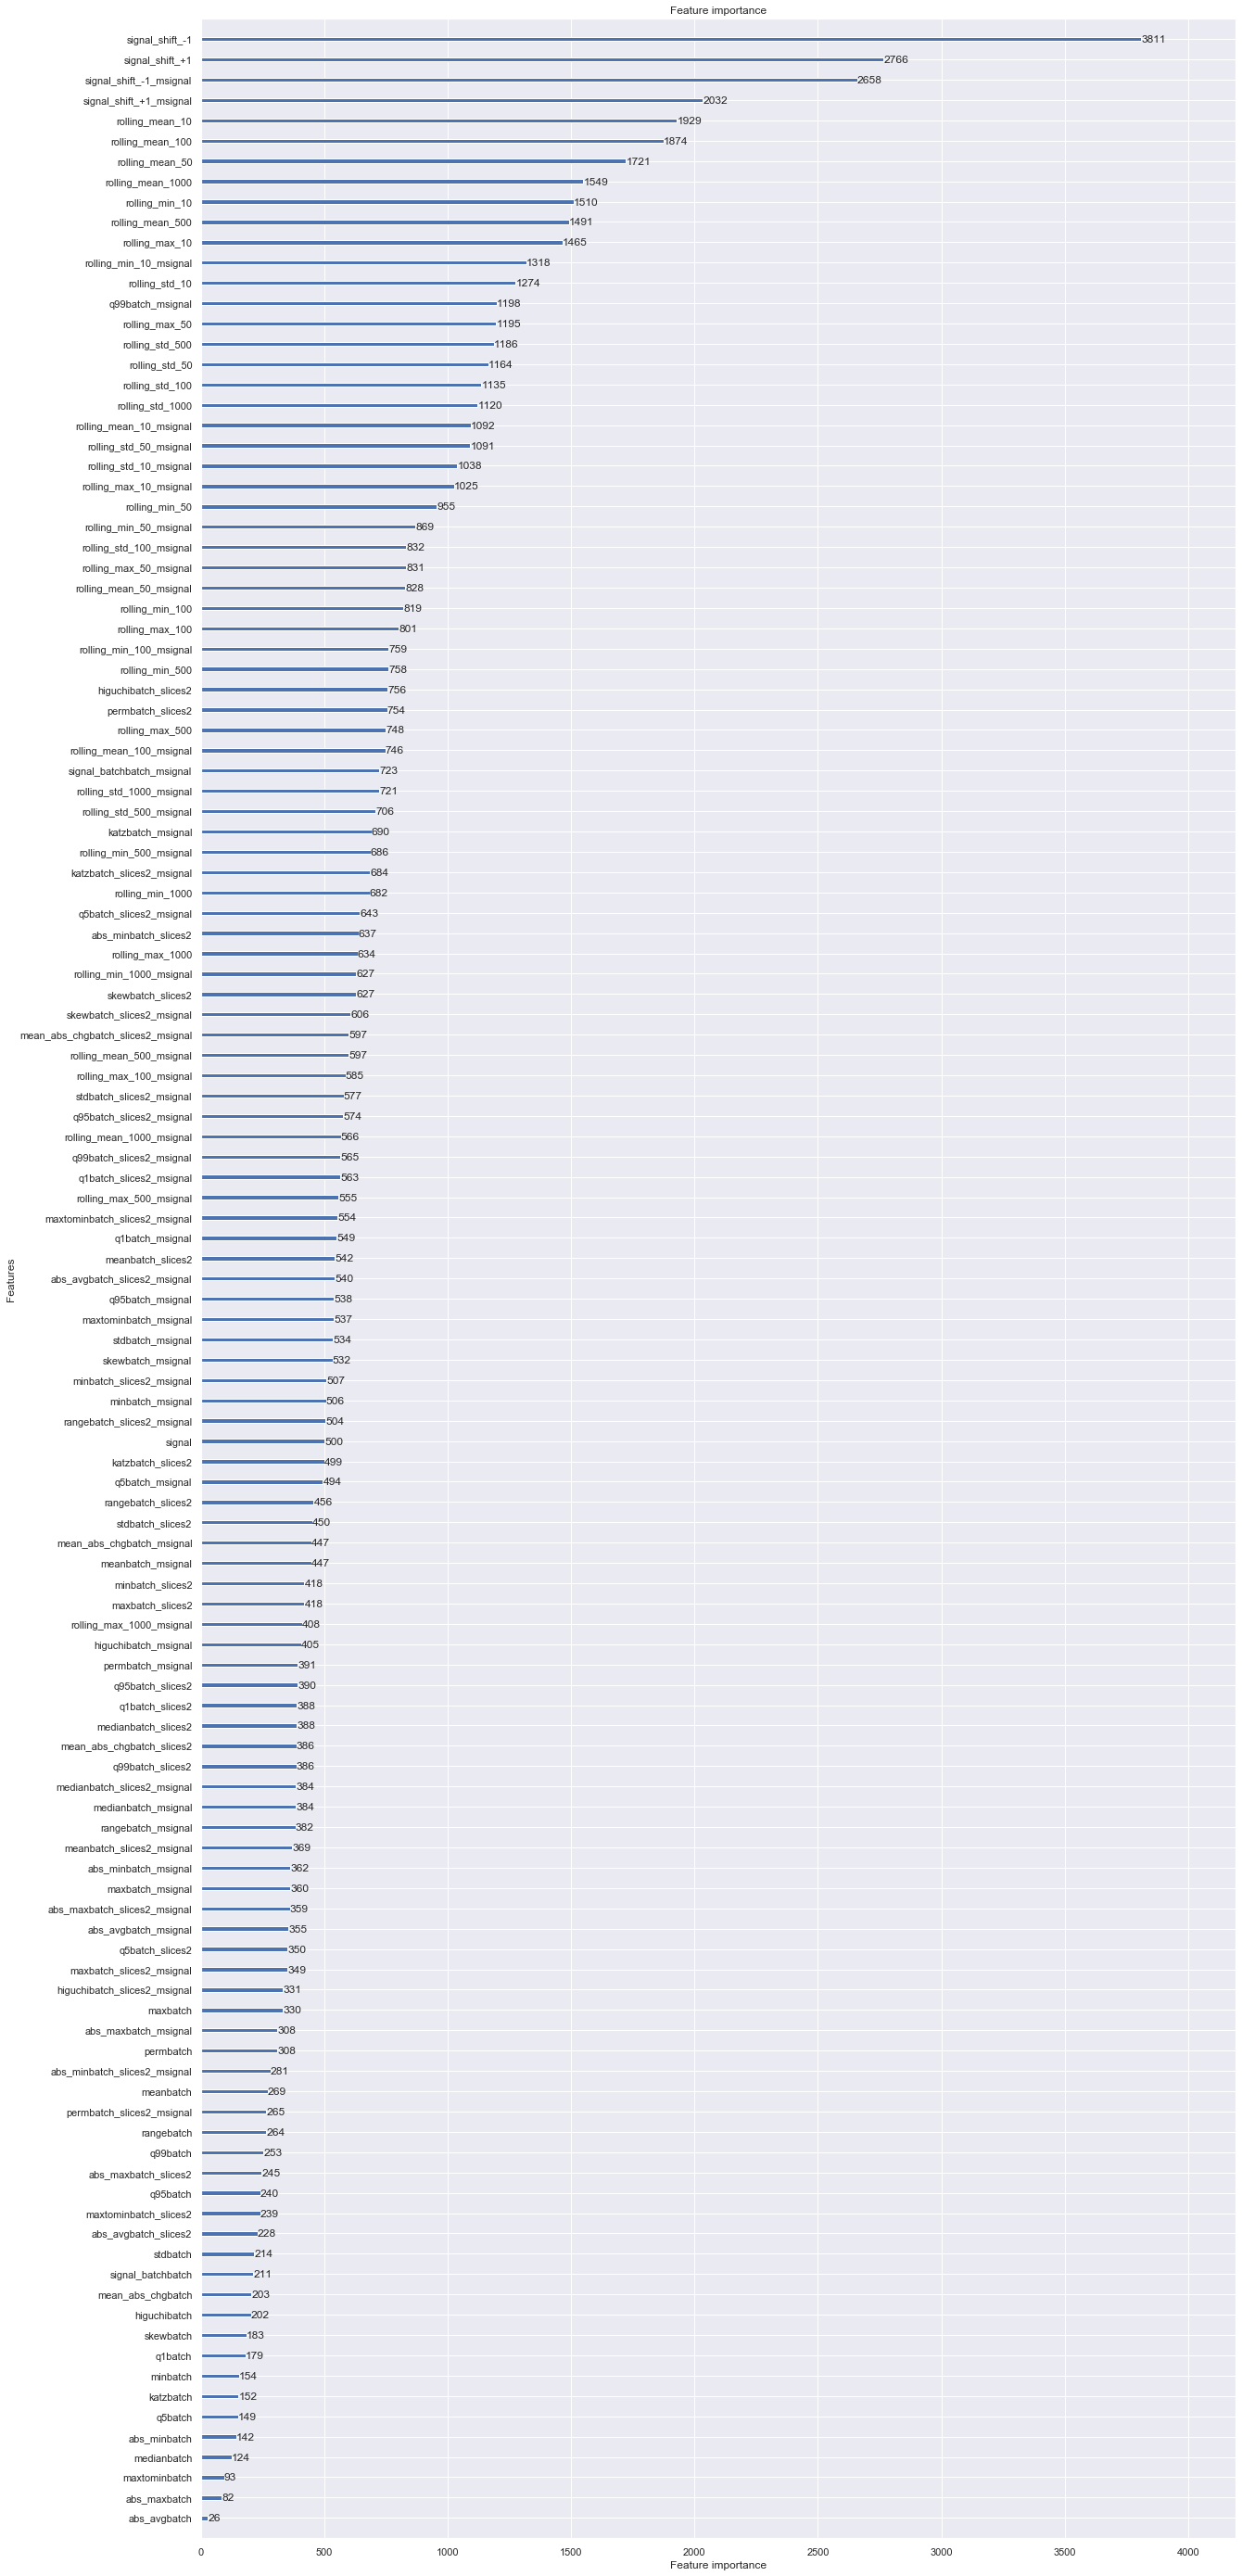

In [63]:
lgb.plot_importance(model,importance_type='split', max_num_features=200, figsize=(20, 50))